# Testing

Using this notebook to test the code used in the mhw calculations

it is also the place where mmm file was calculated

Does so by just working on one time spatial point!



In [28]:
import xarray as xr
from dask.distributed import Client
import dask.array as da
from dask import delayed
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

#### start a local Dask client

In [29]:
from dask.distributed import Client
import dask

# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

#cluster = LocalCluster(
#    n_workers=28,          # Number of workers
#    threads_per_worker=1 #Threads per worker
#    #memory_limit='8GB' # Memory limit per each worker commented out
#)
#client = Client(cluster)

client = Client()
client

2024-07-01 20:57:07,779 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-07-01 20:57:07,796 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-07-01 20:57:07,804 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-mmem-bdw-0001.gadi.nci.org.au/38177/proxy/8787/status,
Dashboard: /node/gadi-mmem-bdw-0001.gadi.nci.org.au/38177/proxy/8787/status,Workers: 32
Total threads: 32,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39955,Workers: 32
Dashboard: /node/gadi-mmem-bdw-0001.gadi.nci.org.au/38177/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41383,Total threads: 1
Dashboard: /node/gadi-mmem-bdw-0001.gadi.nci.org.au/38177/proxy/33311/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39171,


In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
coords_to_drop =['st_edges_ocean','nv','st_ocean']
vars_to_drop =['Time_bounds','average_DT','average_T1','average_T2','st_ocean']

# preprocesser to drop unwanted variables
def drop_stuff(ds, coords_to_drop,vars_to_drop):
    """
    Preprocessor function to drop specified coordinates and variables from a dataset loaded via xr.open_mfdataset

    Parameters:
        ds (xarray.Dataset): The dataset from which coordinates & variables are to be dropped.
        coords_to_drop (list of str): List of coordinate names to drop.
        vars_to_drop(list of str): List of variable names to drop

    Returns:
        xarray.Dataset: Dataset with specified coordinates and variables dropped.
    """
    # Drop coordinates if they are in the dataset
    ds = ds.drop_vars(coords_to_drop, errors='ignore')
    ds = ds.drop_vars(vars_to_drop, errors='ignore')
    return ds

In [58]:
def process_mmm(ds, time_dim, start, end, variable, period):
# Compute the climatological monthly maximum value
    # Rechunk the data along the time dimension
#    data = getattr(ds, variable).sel(**{time_dim: slice(start, end)}).\
#        chunk({'Time': -1, 'xt_ocean': 50, 'yt_ocean': 50}).persist()
    data = getattr(ds, variable).sel(**{time_dim: slice(start, end)}).persist()

    # Debug: Print the shape and chunking of the data
    print(f"Processing period {period},{start},{end} data shape: {data.shape}, chunks: {data.chunks}")

    # Calculate the 90th percentile
    mmm1 = data.resample(Time='1M').mean()
    mmm = mmm1.max(dim=time_dim)

    # Define the output file path
    file = f'/g/data/ia39/ncra/ocean/mhw/{variable}_mmm_{period}.nc'
    mmm.to_netcdf(file, compute=True)
    return mmm

# Read in existing Climatological monthly maximum
def read_mmm(period):
#    period='current'
    variable='temp'
    file =  f'/g/data/ia39/ncra/ocean/mhw/{variable}_mmm_{period}.nc'
    mmm= xr.open_dataset(file)['temp']
    return mmm
    

In [33]:
%%time
# Degree Heating Week Calculate 
def calculate_dhw(sst1, mmm1, period, start, end):
    mmmp1= mmm1 +1  # monthly mean maximum + 1
# Compute hotspots and mask values less than 1
    sst_hotspot = sst1 - mmm1 # p1
    hmask = sst_hotspot >= 1  
    dhd = (sst_hotspot * hmask).persist()
# Calculate the cumulative sum over a 12-week period to get DHD
# convert from degree-days to degree-weeks
    dhw = (dhd.rolling(time=84, center=False).sum() * 1/7).persist()
# compute annual maximum of dhw 
    ymax=dhw.groupby('time.year').max('time')
    dhw = dhw.rename('dhw').assign_attrs(units='degrees C week')
    ymax = ymax.rename('dhw_max').assign_attrs(units='degrees C week')
    dhd = dhd.rename('dhd').assign_attrs(units='degrees C day')

    result = xr.merge([sst_hotspot,dhd,dhw,ymax])

    return result
    


CPU times: user 31 µs, sys: 62 µs, total: 93 µs
Wall time: 121 µs


In [34]:
# Define the periods for processing
GWL_periods = {
    'current': ('1995-01-01', '2014-12-31'),
    'GW1p2': ('2001-01-01', '2020-12-31'),
    'GW1p5': ('2015-01-01', '2034-12-31'),
    'GW2p0': ('2030-01-01', '2049-12-31'),
    'GW3p0': ('2053-01-01', '2072-12-31'),
    'GW4p0': ('2074-01-01', '2093-12-31')
}

# Directory paths for SST
dir1_new = '/g/data/fp2/OFAM3/jra55_historical.1/surface/'
dir2_new = '/g/data/fp2/OFAM3/jra55_rcp8p5/surface/'

# Load datasets with chunking
pattern0=sorted(glob(dir1_new + 'ocean_temp_sfc*.nc'))
# need to get the additional data from historical run to cover the early 2000s
pattern1=sorted(glob(dir1_new + 'ocean_temp_sfc*200[0-5]*.nc'))
pattern2=sorted(glob(dir2_new + 'ocean_temp_sfc*.nc'))

dsst1 = xr.open_mfdataset(pattern0, parallel=True, 
        preprocess = lambda x: drop_stuff(x,coords_to_drop, vars_to_drop)).squeeze()
dsst2 = xr.open_mfdataset(pattern1+pattern2, parallel=True, 
        preprocess = lambda x: drop_stuff(x,coords_to_drop, vars_to_drop)).squeeze()


## Playing 

In [66]:
%%time
qcal=False
#qcal=True
# calculate the climatological monthly maximum for historical data
if qcal :
    period = 'current'
    (start,end)=GWL_periods[period]
    mmm= process_mmm(dsst1, 'Time', start, end, 'temp', period)
    period = 'GW1p2'
    (start,end)=GWL_periods[period]
    mmm= process_mmm(dsst2, 'Time', start, end, 'temp', period)
else:
    mmm=read_mmm('current')
#    mmm=read_mmm('GW1p2')

mmm

CPU times: user 38.3 ms, sys: 27.1 ms, total: 65.3 ms
Wall time: 70.6 ms


<xarray.DataArray 'temp' (yt_ocean: 1500, xt_ocean: 3600)> Size: 22MB
[5400000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95

In [67]:
sst=dsst2.temp
sst

<xarray.DataArray 'temp' (Time: 37255, yt_ocean: 1500, xt_ocean: 3600)> Size: 805GB
dask.array<getitem, shape=(37255, 1500, 3600), dtype=float32, chunksize=(31, 1500, 3600), chunktype=numpy.ndarray>
Coordinates:
  * Time      (Time) datetime64[ns] 298kB 2000-01-01T12:00:00 ... 2101-12-31T...
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [68]:
# select a point to test the MHW code
xlat=10; xlon= 190
sst1 = sst.sel(yt_ocean=xlat, xt_ocean=xlon, method='nearest')
mmm1 = mmm.sel(yt_ocean=xlat, xt_ocean=xlon, method='nearest')
#sst1=sst
sst1 = sst1.rename({"Time":"time"})

sst1= sst1.sel(time=slice('2039-01-01', '2060-12-31'))

# number of years in the slice
nshape= np.shape(sst1)
nyears=np.int(nshape[0]/365.25+.5)
print(nyears)
print(mmm1.values)

22
29.275969


In [69]:
29.275969

29.275969

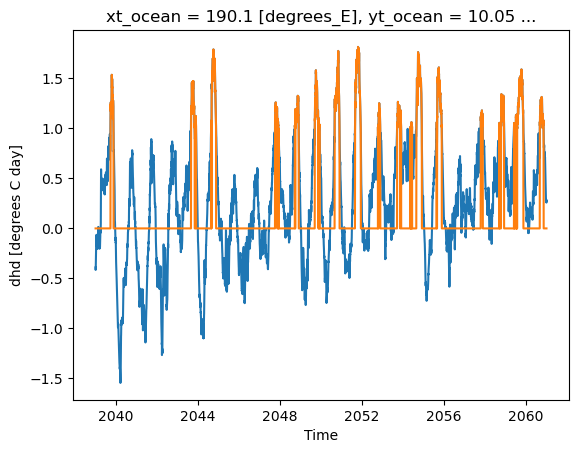

In [70]:
rr=calculate_dhw(sst1, mmm1, 'now', '2039-01-01','2060-12-31')
rr.temp.plot()
rr.dhd.plot()

CPU times: user 6 µs, sys: 12 µs, total: 18 µs
Wall time: 46.3 µs


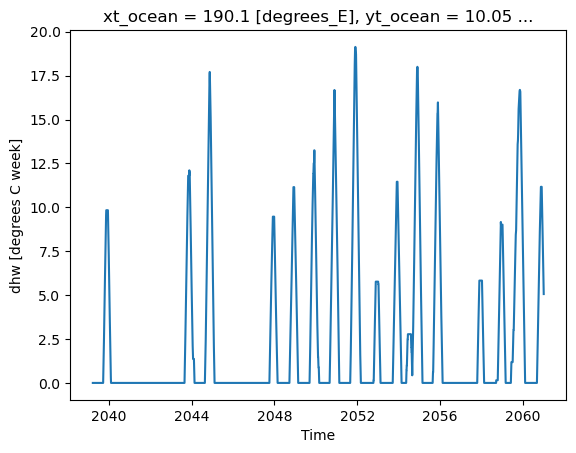

In [71]:
%time
# DHW
rr.dhw.plot()

array(19.136234, dtype=float32)

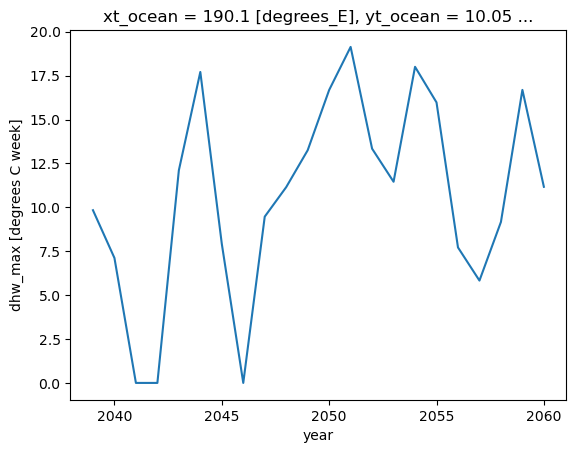

In [72]:
rr.dhw_max.plot()
rr.dhw_max.max('year').values

In [43]:
rr.dhw_max.max('year').values

array(19.136234, dtype=float32)

In [ ]:
#client.close()